In [0]:
import pandas as pd
import requests
from geopy.geocoders import Nominatim
import numpy as np
CLIENT_ID = 'XUA4FYSCWVWXUAA4S0AQXMHX3ELRP00BSXRDWVG0JRKMDNRF'
CLIENT_SECRET = 'MZ34S1OZWYVH1MDOAZKYCJPP0HLQVBIWOUFI1ZHEYHJVY2PW'
VERSION = '20191231'

#Objective: Find if opening a cafe next to a competitor is a good idea

#Part 1: Data Collection

## Step 1: define all the functions that will give us the requests from Foursquare

In [0]:
def explore(lat,lng,rad=500,query='cafe',limit=100,sortP=0,sortD=0):
  url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}&sortByPopularity={}&sortByDistance={}'.format(
              CLIENT_ID, 
              CLIENT_SECRET, 
              VERSION, 
              lat, 
              lng, 
              rad,
              limit, 
              query,
              sortP,
              sortD)
  a=requests.get(url).json()
  a=a['response']['groups'][0]['items']
  return(a)

#This function will return the explores around lat,lng.
#[0]['venue']['location']['lat']
#[0]['venue']['location']['lng']
#[0]['venue']['name']
#[0]['venue']['id']

In [0]:
def recommend(id):
  url='https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(
      id,CLIENT_ID,CLIENT_SECRET,VERSION)
  d=requests.get(url).json()
  d=d['response']['likes']['count']
  return(d)

In [0]:
def coordinates(neighborhood):
  geolocator = Nominatim(timeout=3)
  location = geolocator.geocode(neighborhood + ',Athens,Greece')
  return(location.latitude,location.longitude)

## Step 2: Find the neighborhoods

In [0]:
neigh=pd.read_html('https://www.citypopulation.de/php/greece-athens.php') # website with all neighborhoods of athens

In [0]:
neigh1=neigh[0]['Name'].apply(lambda x: x.split('[')[1])

In [0]:
neighborhoods=[i[:-1] for i in neigh1] # final list that contains all of them

In [0]:
del neighborhoods[7] # it has the same neighborhood twice for some reason

Now we want to find the coordinates of those neighborhoods, but Nominatim does not always work. So we will call it and if it works good, otherwise we will add it later on manually

In [0]:
neighborhoods_coordinates=[]
for i in neighborhoods:
  helplist=[]
  try:
    a,b=coordinates(i)
    helplist.append(a)
    helplist.append(b)
  except:
    pass
  helplist.append(i)
  neighborhoods_coordinates.append(helplist)

/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


So it failed for the following, which we can put in back manually

In [0]:
neighborhoods_coordinates[17]=[38.040999836,23.754663648,'Irakleio']
#neighborhoods_coordinates[20]=[37.961782,23.618335,'Keratsini-Drapetsona']
#neighborhoods_coordinates[23]=[38.0625172,23.7946578,'Lykovrysi-Pefki']
#neighborhoods_coordinates[27]=[37.944288,23.711756,'Nea Smyrni']
#neighborhoods_coordinates[30]=[38.002648,23.798605,'Papagou-Cholargos']
neighborhoods_coordinates[33]=[37.965609,23.567709,'Perama']
#neighborhoods_coordinates[34]=[38.010972,23.6887449,'Peristeri']
#neighborhoods_coordinates[37]=[37.959333,23.751301,'Vyronas']

## Step 3: Find the cafes around those neighborhoods

In [0]:
cafe_id=[]
cafe_name=[]
cafe_lat=[]
cafe_lng=[]
cafe_neighborhood=[]
for j in neighborhoods_coordinates:
  a=explore(j[0],j[1],rad=3000,sortD=1)
  for i in range(len(a)):
    cafe_id.append(a[i]['venue']['id'])
    cafe_lat.append(a[i]['venue']['location']['lat'])
    cafe_lng.append(a[i]['venue']['location']['lng'])
    cafe_name.append(a[i]['venue']['name'])
    cafe_neighborhood.append(j[2])

In [0]:
cafes=pd.DataFrame()
cafes['id']=cafe_id
cafes['name']=cafe_name
cafes['lat']=cafe_lat
cafes['lng']=cafe_lng
cafes['neighborhood']=cafe_neighborhood
cafes.head(3)

,id,name,lat,lng,neighborhood
0,513b7cfbe4b0334da3ca912f,Ethno Cafe,38.004744,23.822445,Agia Paraskevi
1,4bddd6bf0ee3a593d7da2eb0,Posto Γωνιά,38.008841,23.825496,Agia Paraskevi
2,528d1c7511d2543b73dcb571,Lola,38.009057,23.825464,Agia Paraskevi


There are duplicates for sure!

In [0]:
cafes=cafes.drop_duplicates(subset='id')
cafes.reset_index(drop=False,inplace=True)
del cafes['index']
print('There were found {} unique cafes in Athens, Greece.'.format(cafes.shape[0]))

There were found 1771 unique cafes in Athens, Greece.


## Step 4: Find the likes each cafe got

Now there will be a problem. We do not have enough api calls to do it at once. So I will do it in 3 steps, changing keys each time.

In [0]:
likes=[]

In [0]:
for i in range(len(likes),900): # I have already used 40 api calls, so the first time I will be left with around 900 to use
  likes.append(recommend(cafes['id'][i]))

In [0]:
#Changed the key
for i in range(900,1771):  # Each key has 950 calls.
  likes.append(recommend(cafes['id'][i]))

In [0]:
cafes['likes']=likes
cafes.head(3)

,id,name,lat,lng,neighborhood,likes
0,513b7cfbe4b0334da3ca912f,Ethno Cafe,38.004744,23.822445,Agia Paraskevi,17
1,4bddd6bf0ee3a593d7da2eb0,Posto Γωνιά,38.008841,23.825496,Agia Paraskevi,29
2,528d1c7511d2543b73dcb571,Lola,38.009057,23.825464,Agia Paraskevi,95


##Step 5: Find the cafes around each cafe (50 meters)

We will use the lat and lng of each cafe to find the cafes around those coordinates in a radius of 50 meters.

In [0]:
NumberOfComp=[]
Comp=[]

In [0]:
for i in range(len(Comp),940):                                                       
  a=explore(cafes['lat'][i],cafes['lng'][i],rad=50,sortD=1)
  NumberOfComp.append(len(a)-1)                                              #we want to substract one because the search will include the cafe itself
  helplist=[]
  for j in range(1,len(a)):                                                  #again we do not want to include the first entry, for the same reason as above
    helplist.append(a[j]['venue']['id'])
  Comp.append(helplist)

In [0]:
for i in range(len(Comp),1771):
  a=explore(cafes['lat'][i],cafes['lng'][i],rad=50,sortD=1)
  NumberOfComp.append(len(a)-1)
  helplist=[]
  for j in range(1,len(a)):
    helplist.append(a[j]['venue']['id'])
  Comp.append(helplist)

In [0]:
cafes['number']=NumberOfComp
cafes['competitors']=Comp
cafes.head(3)

,id,name,lat,lng,neighborhood,likes,number,competitors
0,513b7cfbe4b0334da3ca912f,Ethno Cafe,38.004744,23.822445,Agia Paraskevi,17,0,[]
1,4bddd6bf0ee3a593d7da2eb0,Posto Γωνιά,38.008841,23.825496,Agia Paraskevi,29,2,"[528d1c7511d2543b73dcb571, 58298ab63398744fe40..."
2,528d1c7511d2543b73dcb571,Lola,38.009057,23.825464,Agia Paraskevi,95,1,[4bddd6bf0ee3a593d7da2eb0]


##Step 6: Find the average likes of competitors

In [0]:
def avg(a):
  count=0
  for i in a:
    count = count + i
  return(count/len(a))

In [0]:
average=[]

In [0]:
for i in range(len(average),1771):                         
  lst=cafes['competitors'][i]               
  a=len(lst)                                     # a is the lenght of the list of competitors
  if a==0:                                
    average.append('NA')
  else:                                      
    helplist=[]                    
    for j in lst:                                # Now take an element in the list of competitors
      try:
        b=cafes[cafes['id']==j]['likes']    #check if we can find that competitors like count in our data frame
      except:                                                   # so we do not waste calls
        b=recommend(j)                                             # else find it normally
      helplist.append(b)                          #Put the likecount in a list
    average.append(avg(helplist))

In [0]:
cafes['average']=average
cafes.head()

,id,name,lat,lng,neighborhood,likes,number,competitors,average
0,513b7cfbe4b0334da3ca912f,Ethno Cafe,38.004744,23.822445,Agia Paraskevi,17,0,[],NA
1,4bddd6bf0ee3a593d7da2eb0,Posto Γωνιά,38.008841,23.825496,Agia Paraskevi,29,2,"[528d1c7511d2543b73dcb571, 58298ab63398744fe40...",57.5
2,528d1c7511d2543b73dcb571,Lola,38.009057,23.825464,Agia Paraskevi,95,1,[4bddd6bf0ee3a593d7da2eb0],29
3,58298ab63398744fe40dd9fd,kupa,38.008692,23.825898,Agia Paraskevi,20,1,[4bddd6bf0ee3a593d7da2eb0],29
4,4e208e4788774a43b76095ff,North,38.006977,23.827127,Agia Paraskevi,64,3,"[543d6db6498ea549c8ed8cee, 549c9af7498e6de3ba3...",245.333


## Step 7: Create last DataFrame

In [0]:
cafe=pd.DataFrame()
cafe['id']=cafes['id']
cafe['name']=cafes['name']
cafe['neighborhood']=cafes['neighborhood']
cafe['number']=cafes['number']
cafe['average']=cafes['average']
cafe['likes']=cafes['likes']

In [0]:
cafe.to_csv('cafes50.csv',index=False)

# Part 2: Data Processing

In [0]:
import pandas as pd
import numpy as np
df=pd.read_csv('cafes50.csv')
import matplotlib.pyplot as plt 
% matplotlib inline
df.head(1)

,id,name,neighborhood,number,average,likes
0,513b7cfbe4b0334da3ca912f,Ethno Cafe,Agia Paraskevi,0,NaN,17


## Remove big chain cafes

In [0]:
Cafe_names=[]
Cafe_count=[]
for i in df['name']:
  count=0
  Cafe_names.append(i)
  for j in df['name']:
    if i==j:
      count += 1
  Cafe_count.append(count)

In [0]:
Big_Chain_Cafe=[]
for j,i in enumerate(Cafe_count):
  if i>1:
    Big_Chain_Cafe.append(Cafe_names[j])

In [0]:
#remove duplicates
Big_Chainz=[]
for i in Big_Chain_Cafe:
  if i not in Big_Chainz:
    Big_Chainz.append(i)
print('Some examples of Big Chain Cafes are: {}'.format(Big_Chainz[0:5]))
print('There were {} cafe chains found'.format(len(Big_Chainz)))

Some examples of Big Chain Cafes are: ['North', 'Kitchen Lab', 'Opus', 'Coffee Brands', 'Starbucks']
There were 60 cafe chains found


In [0]:
for i in Big_Chainz:
  df=df[df['name'] != i]
df.reset_index(drop=False,inplace=True)
del df['index']

## Examine Neighborhoods

In [0]:
neighborhood=pd.DataFrame()
neighborhood['neighborhood']=sorted(df['neighborhood'].unique())
neighborhood['count']=[i for i in df.groupby('neighborhood')['id'].count()]
neighborhood['Average Likes']=[i for i in df.groupby('neighborhood')['likes'].mean()]
neighborhood.head(3)

,neighborhood,count,Average Likes
0,Agia Paraskevi,85,169.623529
1,Agia Varvara,80,74.237500
2,Alimos,89,67.269663


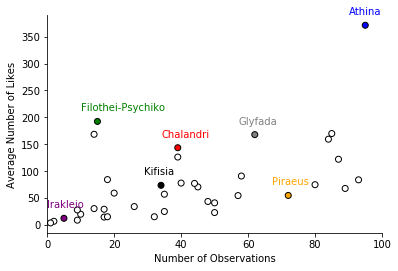

In [0]:
ax=plt.subplot()

List_I_Want_Annotated=[3,12,19,15,34,5,10]
Colors_Of_Future_Annotated=['blue','red','green','grey','purple','black','orange']
Colors_Of_Future_Annotated2=Colors_Of_Future_Annotated.copy()
Color=[]
for i in range(38):
  if i not in List_I_Want_Annotated:
    Color.append('White')
  else:
    Color.append(Colors_Of_Future_Annotated[0])
    del Colors_Of_Future_Annotated[0]

plt.scatter(neighborhood['count'],neighborhood['Average Likes'],edgecolor='black',color=Color)

for i,text in enumerate(neighborhood['neighborhood'],0):
  if i in List_I_Want_Annotated:
    ax.annotate(text,(neighborhood['count'][i],neighborhood['Average Likes'][i]),
                xytext=(neighborhood['count'][i]-5,neighborhood['Average Likes'][i]+20),
                color=Colors_Of_Future_Annotated2[0])
    del Colors_Of_Future_Annotated2[0]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlim((0,100))

plt.xlabel('Number of Observations')
plt.ylabel('Average Number of Likes')

plt.show()

## Examine Dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


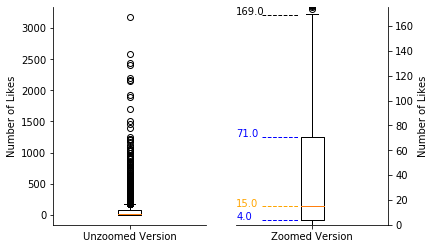

In [0]:
fig=plt.figure()

plt.subplot(121)
ax1=plt.subplot(121)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.ylabel('Number of Likes')
plt.boxplot(df['likes'],labels=['Unzoomed Version'])

plt.subplot(122)
plt.boxplot(df['likes'],labels=['Zoomed Version'])
ax2=plt.subplot(122)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
plt.ylabel('Number of Likes')
plt.ylim([0,175])
c=['blue','orange','blue','black']
for j,i in enumerate([0.25,0.5,0.75,0.858]):
  ax2.axhline(xmin=0.17,xmax=0.41,y=np.quantile(df['likes'],i),color=c[j],linewidth=1,linestyle='dashed')
  plt.annotate(s='{}'.format(round(np.quantile(df['likes'],i),1)),xy=(0.5,np.quantile(df['likes'],i)),color=c[j])

plt.show()

So there are big differences between high likes cafes and low likes cafes. To lower the impact that high cafes have on the average we will take the cube root of each cafe's likes.

In [0]:
df['likes']=df['likes']**(1/3)

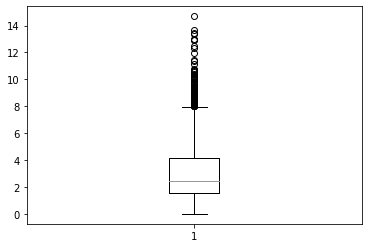

In [0]:
plt.boxplot(df['likes']);

ok it looks better

##Adjust the DataSet for the neighborhood

Each neighborhood is different and some are more beneficial than others.

In [0]:
df1=pd.DataFrame()
df1['name']=sorted(df['neighborhood'].unique())

median=[]
for i in df1['name']:
  a=np.quantile(df[df['neighborhood']==i]['likes'],0.5)
  median.append(a)
df1['50']=median

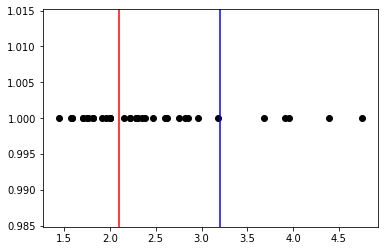

In [0]:
plt.scatter(df1['50'],[1 for i in range(38)],color='black')
plt.axvline(x=2.1,color='red')
plt.axvline(x=3.2,color='blue')

In [0]:
for j,i in enumerate(df1['50']):
  if i>3.2:
    print('{} has {} rating'.format(df1['name'][j],i))

Athina has 4.7474593985234 rating
Chalandri has 3.6840314986403864 rating
Dafni-Ymittos has 4.3967620511649965 rating
Filothei-Psychiko has 3.9148676411688634 rating
Vyronas has 3.9578916096804053 rating


We will put each cafe in one of those 3 categories as above

In [0]:
def find_cat(n):
  a=df1[df1['name']==n]['50'][sorted(df['neighborhood'].unique()).index(n)]
  if a<2.1:
    return(0)
  elif a<3.2:
    return(1)
  else:
    return(2)

print('Example find_cat("Athina")={}'.format(find_cat('Athina')))

Example find_cat("Athina")=2


In [0]:
df['category']=[find_cat(df['neighborhood'][i]) for i in range(df.shape[0])]
df.head(3)

,id,name,neighborhood,number,average,likes,category
0,513b7cfbe4b0334da3ca912f,Ethno Cafe,Agia Paraskevi,0,NaN,2.571282,1
1,4bddd6bf0ee3a593d7da2eb0,Posto Γωνιά,Agia Paraskevi,2,57.5,3.072317,1
2,528d1c7511d2543b73dcb571,Lola,Agia Paraskevi,1,29,4.562903,1


Now we would like to find the median of each category

In [0]:
medians=[]
for i in range(3):
  a=np.quantile(df[df['category']==i]['likes'],0.5)
  medians.append(a)
medians

[1.912931182772389, 2.5198420997897464, 4.216413163900862]

Now we want to compare how each cafe did to the median of its category. We will divide the likes by the median of each group.

In [0]:
df['category median']=[medians[df['category'][i]] for i in range(df.shape[0])]
df.head(2)

,id,name,neighborhood,number,average,likes,category,category median
0,513b7cfbe4b0334da3ca912f,Ethno Cafe,Agia Paraskevi,0,NaN,2.571282,1,2.519842
1,4bddd6bf0ee3a593d7da2eb0,Posto Γωνιά,Agia Paraskevi,2,57.5,3.072317,1,2.519842


In [0]:
df['rating']=df['likes']/df['category median']
df.head(2)

,id,name,neighborhood,number,average,likes,category,category median,rating
0,513b7cfbe4b0334da3ca912f,Ethno Cafe,Agia Paraskevi,0,NaN,2.571282,1,2.519842,1.020414
1,4bddd6bf0ee3a593d7da2eb0,Posto Γωνιά,Agia Paraskevi,2,57.5,3.072317,1,2.519842,1.219250


##Recheck Boxplot

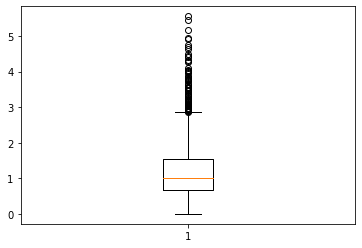

In [0]:
plt.boxplot(df['rating']);

## Groupyby number of competitors

In [0]:
number=pd.DataFrame()
number['Average Rating']=[i for i in df.groupby('number')['rating'].mean()]
number['count']=[i for i in df.groupby('number')['id'].count()]
number

,Average Rating,count
0,1.102016,726
1,1.243370,370
2,1.343927,157
3,1.389701,116
4,1.265879,78
5,1.214428,39
6,1.514053,24
7,1.369749,11
8,1.794133,8
9,1.727233,8


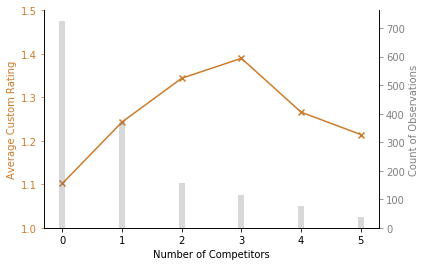

In [0]:
limit=6
color1='#cc7b2b'
color2='grey'

plt.figure()

ax1=plt.subplot(111)
plt.scatter(range(limit),number['Average Rating'][0:limit],color=color1,marker='x')
plt.plot(range(limit),number['Average Rating'][0:limit],color=color1)
plt.ylim([1,1.5])
plt.title('')
plt.xlabel('Number of Competitors')
plt.ylabel('Average Custom Rating',color=color1)
ax1.spines['top'].set_visible(False)
ax1.yaxis.label.set_color(color1)
ax1.tick_params(axis='y', colors=color1)

ax2 = ax1.twinx()
plt.bar(range(limit), number['count'][0:limit],color=color2,width=0.1,alpha=0.3)
ax2.tick_params(axis='y', colors=color2)
ax2.yaxis.label.set_color(color2)
ax2.spines['top'].set_visible(False)
plt.ylabel('Count of Observations',color=color2)

plt.show()

So that is looking by average. But we might think that average is not the best metric.

In [0]:
list_of_groups=[[] for i in range(12)]
for i in range(12):
  for j in range(len(df['number'])):
    if df['number'][j]==i:
      list_of_groups[i].append(df['rating'][j])

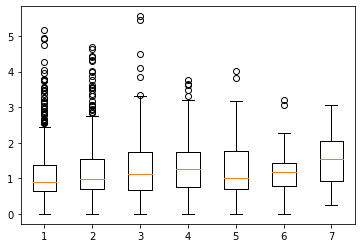

In [0]:
plt.boxplot([list_of_groups[i] for i in range(7)]);

Or looking it another way:

In [0]:
limit=4
lst=[[] for i in range(limit)]
for j in range(limit): 
  for i in np.arange(0.25,0.75,0.01):
    a=np.quantile(list_of_groups[j],i)
    lst[j].append(a)

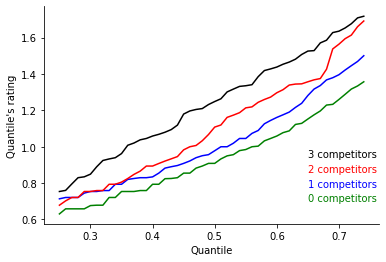

In [0]:
c=['green','blue','red','black']
ax=plt.subplot()
for i in range(limit):
  plt.plot(np.arange(0.25,0.75,0.01),lst[i],color=c[i]);
  plt.annotate(s='{} competitors'.format(i), xy=(0.65,0.7+i*0.08),color=c[i])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Quantile')
plt.ylabel("Quantile's rating");


#FAILED ATTEMPTS

In [0]:
df=pd.read_csv('cafes50.csv')

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

## Step 1: A graph of neighborhoods

In [0]:
neighborhood=pd.DataFrame()
neighborhood['neighborhood']=sorted(df['neighborhood'].unique())
neighborhood['count']=[i for i in df.groupby('neighborhood')['id'].count()]
neighborhood['Average Likes']=[i for i in df.groupby('neighborhood')['likes'].mean()]
neighborhood.head(3)

,neighborhood,count,Average Likes
0,Agia Paraskevi,100,155.32
1,Agia Varvara,100,65.90
2,Alimos,100,63.68


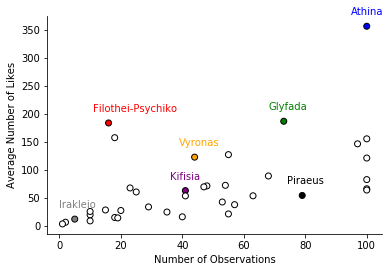

In [0]:
ax=plt.subplot()

List_I_Want_Annotated=[3,12,19,15,34,36,10]
Colors_Of_Future_Annotated=['blue','red','green','grey','purple','black','orange']
Colors_Of_Future_Annotated2=Colors_Of_Future_Annotated.copy()
Color=[]
for i in range(38):
  if i not in List_I_Want_Annotated:
    Color.append('White')
  else:
    Color.append(Colors_Of_Future_Annotated[0])
    del Colors_Of_Future_Annotated[0]

plt.scatter(neighborhood['count'],neighborhood['Average Likes'],edgecolor='black',color=Color)

for i,text in enumerate(neighborhood['neighborhood'],0):
  if i in List_I_Want_Annotated:
    ax.annotate(text,(neighborhood['count'][i],neighborhood['Average Likes'][i]),
                xytext=(neighborhood['count'][i]-5,neighborhood['Average Likes'][i]+20),
                color=Colors_Of_Future_Annotated2[0])
    del Colors_Of_Future_Annotated2[0]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Number of Observations')
plt.ylabel('Average Number of Likes')

plt.show()

Some neighborhoods have many cafes and reach the limit of 100 cafes per search that the api has set (right). Others, have between 40 and 60 (middle). And some have very few (left). 

Athina looks like an extreme outlier compared to other neighborhoods

## Step 2: Take out extreme values

In [0]:
#I removed Athina from the data set
df=pd.read_csv('cafes50NoAthens.csv')
df.shape

(1671, 6)

In [0]:
print("25% of the data is below {} number of likes".format(np.quantile(df['likes'],0.40)))
print("25% of the data is above {} number of likes".format(np.quantile(df['likes'],0.90)))

25% of the data is below 9.0 number of likes
25% of the data is above 200.0 number of likes


In [0]:
low=df[df['likes']<4]
high=df[df['likes']>200]

In [0]:
drop_list=[]
for i in range(1671):
  if df['likes'][i]<10 or df['likes'][i]>200:
    drop_list.append(i)
df.drop(drop_list,inplace=True)
df.reset_index(drop=False,inplace=True)
del df['index']
df.shape

(811, 6)

## Step 3: Group by number of competitors:

In [0]:
number=pd.DataFrame()
number['number']=sorted(df['number'].unique())
number['count']=[i for i in df.groupby('number')['id'].count()]
number['Average Likes']=[i for i in df.groupby('number')['likes'].mean()]
number

,number,count,Average Likes
0,0,814,67.326781
1,1,385,82.566234
2,2,177,118.711864
3,3,121,111.867769
4,4,81,78.407407
5,5,34,53.823529
6,6,23,128.304348
7,7,13,108.538462
8,8,8,140.625000
9,9,5,167.000000


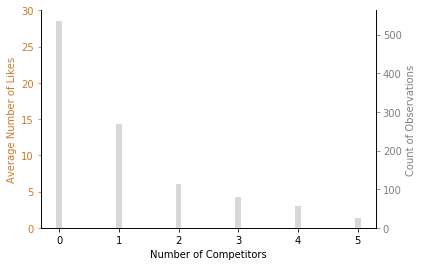

In [0]:
limit=6
color1='#cc7b2b'
color2='grey'

plt.figure()

ax1=plt.subplot(111)
plt.scatter(number['number'][0:limit],number['Average Likes'][0:limit],color=color1,marker='x')
plt.plot(number['number'][0:limit],number['Average Likes'][0:limit],color=color1)
plt.ylim([0,30])
plt.title('')
plt.xlabel('Number of Competitors')
plt.ylabel('Average Number of Likes',color=color1)
ax1.spines['top'].set_visible(False)
ax1.yaxis.label.set_color(color1)
ax1.tick_params(axis='y', colors=color1)

ax2 = ax1.twinx()
plt.bar(number['number'][0:limit], number['count'][0:limit],color=color2,width=0.1,alpha=0.3)
ax2.tick_params(axis='y', colors=color2)
ax2.yaxis.label.set_color(color2)
ax2.spines['top'].set_visible(False)
plt.ylabel('Count of Observations',color=color2)

plt.show()

## Step 3: Boxplot

We would like to see the distribution of each number of competitor

In [0]:
limit=df.shape[0]

NumberOfComp0=[]
for i in range(limit):
  if df['number'][i]==0:
    NumberOfComp0.append(df['likes'][i])

NumberOfComp1=[]
for i in range(limit):
  if df['number'][i]==1:
    NumberOfComp1.append(df['likes'][i])

NumberOfComp2=[]
for i in range(limit):
  if df['number'][i]==2:
    NumberOfComp2.append(df['likes'][i])

NumberOfComp3=[]
for i in range(limit):
  if df['number'][i]==3:
    NumberOfComp3.append(df['likes'][i])

NumberOfComp4=[]
for i in range(limit):
  if df['number'][i]==4:
    NumberOfComp4.append(df['likes'][i])

NumberOfComp5=[]
for i in range(limit):
  if df['number'][i]==5:
    NumberOfComp5.append(df['likes'][i])

(0, 250)

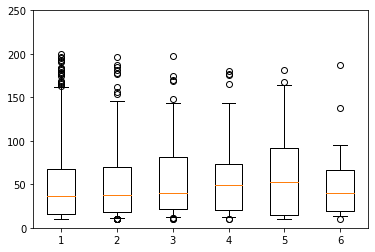

In [0]:
plt.figure()
plt.boxplot([NumberOfComp0,NumberOfComp1,NumberOfComp2,NumberOfComp3,NumberOfComp4,NumberOfComp5],whis=[5,95]);
plt.ylim([0, 250])

The result is ugly!

In [0]:
Quantiles=np.arange(0,1,0.01)
comps=[[],[],[],[],[],[]]
comp=[NumberOfComp0,NumberOfComp1,NumberOfComp2,NumberOfComp3,NumberOfComp4,NumberOfComp5]

for j in range(6):
  for i in Quantiles:
    comps[j].append(np.quantile(comp[j],i))

In [0]:
c=['#0a82fa','#086dd1','#0654a1','#053d75','#032a52','red']

def myplot(x=0,xlim=0.99,colors=c,y='max'):
  
  ax=plt.subplot()

  ylim=int(xlim/0.01)

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  for i in range(6):
    plt.plot(Quantiles,comps[i],color=colors[i])
    ax.annotate(xy=(xlim,comps[i][ylim]),s='{}'.format(i),color=colors[i])

  plt.xlim([x,xlim])
  if y != 'max':
    plt.ylim([0,y])

  plt.xlabel('Quantile')
  plt.ylabel('Average Number of Likes')
  plt.show()

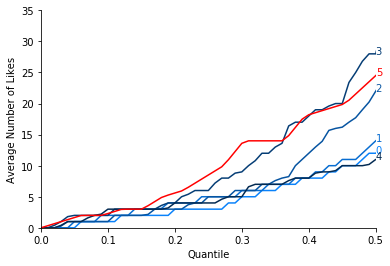

In [0]:
myplot(x=0,xlim=0.5,y=35)

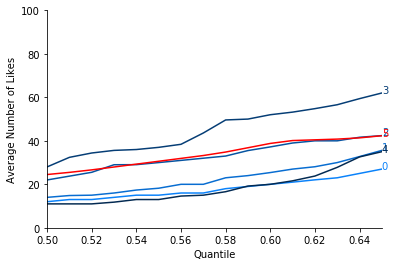

In [0]:
myplot(x=0.5,xlim=0.65,y=100)

## Another histogram

What is the probability that a cafe with x neighborhoods will receive at least x number of likes?

In [0]:
def propability(n,x,l=0):
  count=0
  for i in comp[n]:
    if i>x:
      count +=1
  return(count/len(comp[n]))


In [0]:
probs=[[],[],[],[],[],[]]
for j in range(6):
  for i in range(500):
    probs[j].append(propability(j,i))

(0, 200)

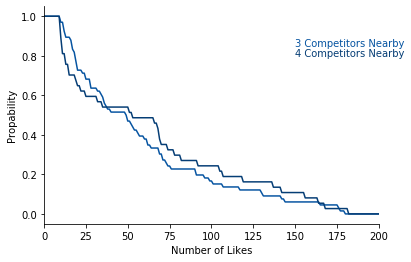

In [0]:
c=['#0a82fa','red','#086dd1','#0654a1','#053d75','#032a52','red']

ax=plt.subplot()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Number of Likes')
plt.ylabel('Propability')

for i in [3,4]:
  plt.plot(probs[i],color=c[i])
  ax.annotate(xy=(150,1-0.05*i),s='{} Competitors Nearby'.format(i),color=c[i])
plt.xlim([0,200])

## Atte,pt2

In [0]:
df=pd.read_csv('cafes50.csv')
import matplotlib.pyplot as plt 
% matplotlib inline

In [0]:
number=pd.DataFrame()
number['Total']=[i for i in df.groupby('number')['id'].count()][0:7]

helplist=[[] for i in range(10)]
for j,i in enumerate(range(10,110,10),0):
  helplist[j]=[i for i in df[df['likes']>i].groupby('number')['likes'].count()][0:7]
  number['{}'.format(i)]=helplist[j]/number['Total']

number

,Total,10,20,30,40,50,60,70,80,90,100
0,814,0.524570,0.394349,0.326781,0.280098,0.233415,0.207617,0.184275,0.167076,0.152334,0.140049
1,385,0.553247,0.428571,0.368831,0.329870,0.272727,0.251948,0.228571,0.212987,0.202597,0.187013
2,177,0.615819,0.508475,0.446328,0.367232,0.333333,0.299435,0.276836,0.259887,0.231638,0.231638
3,121,0.677686,0.545455,0.495868,0.429752,0.404959,0.355372,0.314050,0.272727,0.272727,0.239669
4,81,0.506173,0.395062,0.370370,0.345679,0.345679,0.320988,0.259259,0.234568,0.222222,0.209877
5,34,0.705882,0.529412,0.441176,0.382353,0.294118,0.264706,0.235294,0.205882,0.176471,0.117647
6,23,0.695652,0.695652,0.565217,0.478261,0.478261,0.434783,0.434783,0.434783,0.391304,0.347826


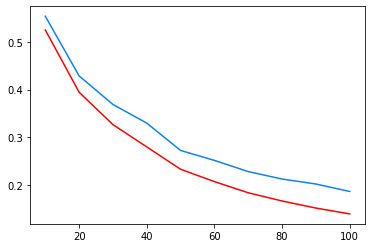

In [0]:
c=['red','#0a82fa','#086dd1','#0654a1','#053d75','#032a52','black']
for i in range(2):
  helplist=[]
  for j in range(10,110,10):
    helplist.append(number.iloc[[i],1:11]['{}'.format(j)][i])
  plt.plot(range(10,110,10),helplist,color=c[i])

We will group in 3 categories:

In [0]:
helplist=[]
for i in range(df.shape[0]):
  if df['number'][i]==0:
    helplist.append('No')
  elif df['number'][i]==1 or df['number'][i]==2:
    helplist.append('Few')
  else:
    helplist.append('Many')

df['Category']=helplist
df.head(2)

,id,name,neighborhood,number,average,likes,Category
0,513b7cfbe4b0334da3ca912f,Ethno Cafe,Agia Paraskevi,0,NaN,17,No
1,4bddd6bf0ee3a593d7da2eb0,Posto Γωνιά,Agia Paraskevi,2,57.5,29,Few


In [0]:
number=pd.DataFrame()
number['Category']=sorted(df['Category'].unique())
number['Count']=[i for i in df.groupby('Category')['id'].count()]
number['Average Likes']=[i for i in df.groupby('Category')['likes'].median()]
number

,Category,Count,Average Likes
0,Few,464,10
1,Many,228,13
2,No,715,9


In [0]:
drop_list=[]
for i in range(df.shape[0]):
  if df['likes'][i]>120:
    drop_list.append(i)
df.drop(drop_list,inplace=True)
df.reset_index(drop=False,inplace=True)
del df['index']
df.shape

(1407, 7)

In [0]:
df=pd.read_csv('cafes50.csv')
import matplotlib.pyplot as plt 
% matplotlib inline

## Examine NeighborHoods

In [0]:
neighborhood=pd.DataFrame()
neighborhood['neighborhood']=sorted(df['neighborhood'].unique())
neighborhood['count']=[i for i in df.groupby('neighborhood')['id'].count()]
neighborhood['Average Likes']=[i for i in df.groupby('neighborhood')['likes'].mean()]
neighborhood.head(3)

,neighborhood,count,Average Likes
0,Agia Paraskevi,100,155.32
1,Agia Varvara,100,65.90
2,Alimos,100,63.68


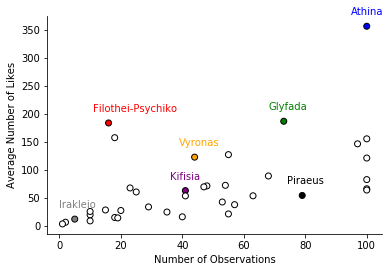

In [0]:
ax=plt.subplot()

List_I_Want_Annotated=[3,12,19,15,34,36,10]
Colors_Of_Future_Annotated=['blue','red','green','grey','purple','black','orange']
Colors_Of_Future_Annotated2=Colors_Of_Future_Annotated.copy()
Color=[]
for i in range(38):
  if i not in List_I_Want_Annotated:
    Color.append('White')
  else:
    Color.append(Colors_Of_Future_Annotated[0])
    del Colors_Of_Future_Annotated[0]

plt.scatter(neighborhood['count'],neighborhood['Average Likes'],edgecolor='black',color=Color)

for i,text in enumerate(neighborhood['neighborhood'],0):
  if i in List_I_Want_Annotated:
    ax.annotate(text,(neighborhood['count'][i],neighborhood['Average Likes'][i]),
                xytext=(neighborhood['count'][i]-5,neighborhood['Average Likes'][i]+20),
                color=Colors_Of_Future_Annotated2[0])
    del Colors_Of_Future_Annotated2[0]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Number of Observations')
plt.ylabel('Average Number of Likes')

plt.show()

## Examine The Dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


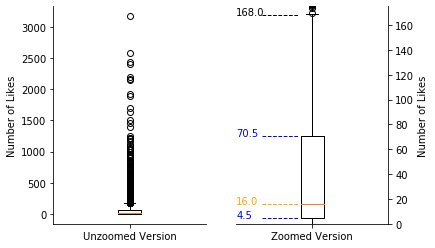

In [0]:
fig=plt.figure()

plt.subplot(121)
ax1=plt.subplot(121)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.ylabel('Number of Likes')
plt.boxplot(df['likes'],labels=['Unzoomed Version'])

plt.subplot(122)
plt.boxplot(df['likes'],labels=['Zoomed Version'])
ax2=plt.subplot(122)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
plt.ylabel('Number of Likes')
plt.ylim([0,175])
c=['blue','orange','blue','black']
for j,i in enumerate([0.25,0.5,0.75,0.8623]):
  ax2.axhline(xmin=0.17,xmax=0.41,y=np.quantile(df['likes'],i),color=c[j],linewidth=1,linestyle='dashed')
  plt.annotate(s='{}'.format(round(np.quantile(df['likes'],i),1)),xy=(0.5,np.quantile(df['likes'],i)),color=c[j])

plt.show();

We see that 86% of the data set is below 168 and 50% is below 16 and 25% is below 4. Anything above 168 will drastically affect any results

Now any normalazation will not help because any addition,substraction, multiplication or division will keep the huge gap between the extremes and the normal observations. So we will remove anything above 168.

In [0]:
a=df.shape[0]
df=df[df['likes']<169]
df.reset_index(drop=False,inplace=True)
del df['index']
print('There were remove {} observations and now there exist {} observations'.format(a-df.shape[0],df.shape[0]))

There were remove 243 observations and now there exist 1528 observations


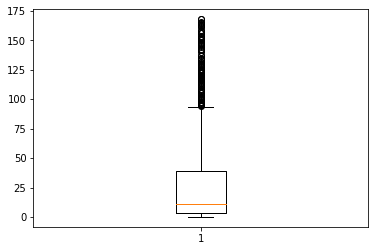

In [0]:
plt.boxplot(df['likes']);

## Adjust the DataSet for the neigborhood

Each neighborhood is different and some are more beneficial than others. So we want to compare each cafe to the average cafe of the neighborhood instead to cafes from other neighborhoods. To take out the effect of the neighborhood we will use the max min formula:

Cafe's Rating = Number Of Likes/ (max in its neighborhood - min in its neighborhood)

In [0]:
MaxMin=pd.DataFrame()
MaxMin['neighborhood']=sorted(df['neighborhood'].unique())
MaxMin['Max']=[i for i in df.groupby('neighborhood')['likes'].max()]
MaxMin['Min']=[i for i in df.groupby('neighborhood')['likes'].min()]
MaxMin['Mean']=[i for i in df.groupby('neighborhood')['likes'].mean()]
MaxMin.head(3)

,neighborhood,Max,Min,Mean
0,Agia Paraskevi,166,0,35.325000
1,Agia Varvara,135,0,23.472527
2,Alimos,165,0,22.923913




```
# This is formatted as code
```

I was wondering if everything has 0 for min.

In [0]:
for j,i in enumerate(MaxMin['Min']):
  if i !=0:
    print ('{} has {} for min'.format(MaxMin['neighborhood'][j],i))

Filothei-Psychiko has 1 for min
Nea Smyrni has 3 for min
Nikaia-Agios Ioannis Rentis has 2 for min
Papagou-Cholargos has 2 for min
Perama has 2 for min
Petroupoli has 1 for min
Vyronas has 1 for min


In [0]:
def GiveMaxMin(c,n): 
  for i in MaxMin[MaxMin['neighborhood']==n][c]:
    return(i)

In [0]:
# Passing it in df
df['max']=[GiveMaxMin('Max',df['neighborhood'][i]) for i in range(df.shape[0])]
df['min']=[GiveMaxMin('Min',df['neighborhood'][i]) for i in range(df.shape[0])]
df['mean']=[GiveMaxMin('Mean',df['neighborhood'][i]) for i in range(df.shape[0])]

df['rating']=df['likes']/df['mean']
#df['rating']=[df['likes'][i]/(df['max'][i]-df['min'][i]) for i in range(df.shape[0])]
df.head(3)

,id,name,neighborhood,number,average,likes,max,min,rating,mean
0,513b7cfbe4b0334da3ca912f,Ethno Cafe,Agia Paraskevi,0,NaN,17,166,0,0.481246,35.325
1,4bddd6bf0ee3a593d7da2eb0,Posto Γωνιά,Agia Paraskevi,2,57.5,29,166,0,0.820948,35.325
2,528d1c7511d2543b73dcb571,Lola,Agia Paraskevi,1,29,95,166,0,2.689314,35.325


## Re check our boxplot

In [0]:
for j,i in enumerate(df['rating']):
  if i>1:
    print('{} is {}'.format(j,i))


663 is 1.00990099009901
664 is 1.00990099009901
885 is 1.125
1054 is 1.5
1133 is inf
1139 is 1.065217391304348
1157 is 1.0285714285714285
1158 is 1.0571428571428572
1195 is 1.0166666666666666
1312 is 1.0714285714285714
1350 is 1.0125
1401 is 1.0063291139240507


It is ok to be above 1, the problem is the one with inf at line 1133. This happens because there is only one cafe in that neighborhood. I will remove any neighborhood with less than 5 cafes. Using a pivot table at excel those neighborhoods are the following.

In [0]:
df=df[df['neighborhood']!='Irakleio']
df=df[df['neighborhood']!='Korydallos']
df=df[df['neighborhood']!='Nea Ionia']
df.reset_index(drop=False,inplace=True)
del df['index']

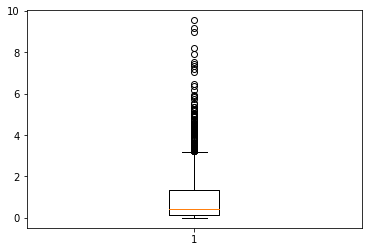

In [0]:
plt.boxplot(df['rating']);

## Group By number of Competitors

In [0]:
number=pd.DataFrame()
number['Average Rating']=[i for i in df.groupby('number')['rating'].mean()]
number['count']=[i for i in df.groupby('number')['id'].count()]
number

,Average Rating,count
0,0.934004,757
1,0.951363,345
2,1.023627,152
3,1.223987,106
4,1.175804,80
5,1.071934,37
6,1.452498,19
7,1.593510,9
8,1.802762,6
9,0.478835,2
